Name: Quang Dong Nguyen  
Student ID: 20744696

---

**About CIFAR:**  
The CIFAR-10 dataset is a collection of images that are commonly used to train machine learning
and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The
CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes
represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each
class. See https://www.cs.toronto.edu/~kriz/cifar.html for details

# Task

Need to accomplish the following tasks for this assignment

1. Randomly select 3 classes with 100 images per class for this assignment;
2. Build the autoencoder model using CNN with functioning training code (if not CNN based, 60% reduction of marks will incur for this task);
3. Plot the learnt images 2D coordinates (normally called *embeddings* in machine learning) of all images in training with each class denoted b a symbol, for example, circles for dogs, triangles for cats and so on;
4. Randomly select 5 images that are not in the training set and obtain their 2D representations, add them to the plot produced in task 3 and describe what do you think about them in terms of their locations in relations to others.
Your code should produce the plot similar to fig 1

## Bonus task

Build a **supervised** manifold learning model on CIFAR-10 images. The main idea is to incorporate labels information in the manifold learning process. It is very similar to LDA (linear discriminant analysis) in terms of functionality. However, instead of a lienar function, we use neural networks autoencoder as the backbone for manifold learning. Therefore, the model is a combination of autoencoder and classification, i.e. incorporating supervision information inthe modelling process, for exmaple, addding classification cost function into original autoencoder cost function. Do task 1-4 (see above) but replace the autoencoder by this supervised one.  
**NOTE: this is extra 10 marks contributing towards your final scores if you can do it**

---

Open the CIFAR - 10 Dataset

Import the library used in this assignment

In [1628]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt

#random split modules
from torch.utils.data import random_split

#to load and normalise CIFAR10
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import ConvTranspose2d

import torchvision
from torchvision import transforms 
from torchviz import make_dot
from torchvision.datasets import CIFAR10
from torchviz import make_dot
import hiddenlayer as hl

**Data Categorisation**

In [1629]:
CIF_dataset = CIFAR10(os.getcwd(), transform = transforms.ToTensor(), download = False) #CIFAR dataset

Select random class from CIF_dataset

In [1630]:
format(CIF_dataset.classes)

"['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']"

In [1631]:
random.seed(1)
random.sample(range(0,9), 3)
#this return 2, 1, 8 which stand for bird, automobile and ship

[2, 1, 8]

And we select 100 for each class

In [1632]:
r1 = list(np.where(np.array(CIF_dataset.targets) == 5)[0])[0:100]
r2 = list(np.where(np.array(CIF_dataset.targets) == 3)[0])[0:100]
r3 = list(np.where(np.array(CIF_dataset.targets) == 7)[0])[0:100]
r_total = r1 + r2 + r3

In [1633]:
dataset_CIF = torch.utils.data.Subset(CIF_dataset, r_total)
len(dataset_CIF) #300 images with 100 per class (3 classes total)

300

**Training, validation and testing set**

In [1634]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset_CIF, [50, 50, 200])

In [1648]:
train_loadpck = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loadpck = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)

---

In [1636]:
#define my own CNN architecture 
class mySmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            #Conv block
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p = 0.1),
            nn.Linear(in_features = 4096, out_features = 128),
            nn.ReLU(inplace = True),
            nn.Dropout(p = 0.1),
            nn.Linear(in_features = 128, out_features =  10),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

model = mySmallCNN()

In [1637]:
def train_model(optimiser, model, loss_function, trainloader, valloader, 
                n_epochs=10, fplotloss=True, fdraw=False, mode=1):
    # move tensors to GPU if CUDA is available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("GPU is available! Train model on GPU.")
        model.cuda()
    
    train_losslist = []
    val_losslist = []
   
    
    # Track the best model so far (evaluated on validation set)
    val_loss_min = np.Inf 
    
    print("Entering training cycles.")
    for epoch in [*range(n_epochs)]:
    
        # keep track of training and validation loss
        train_loss = 0.0
        val_loss = 0.0
        
        # train the model, one training cycle
        model.train()
        for data, target in trainloader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimiser.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            if mode==0:
                loss = loss_function(output, target)
            else: # Be careful with the AE mode training
                loss = loss_function(output[0], data)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimiser.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
 
        # validate the model 
        model.eval()
        for data, target in valloader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            if mode==0:
                loss = loss_function(output, target)
            else: 
                loss = loss_function(output[0], data)
            # update average validation loss 
            val_loss += loss.item() * data.size(0)
        
        # calculate average losses
        train_loss = train_loss / len(trainloader.dataset)
        val_loss = val_loss / len(valloader.dataset)
    
        train_losslist.append(train_loss)
        val_losslist.append(val_loss)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, val_loss))
        
        # save model if validation loss has decreased
        if val_loss <= val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f})')
            val_loss_min = val_loss

    
    # Plot training and validation loss if fplotloss=True
    if fplotloss:
        plt.plot(*range(n_epochs), train_losslist)
        plt.plot(*range(n_epochs), val_losslist)
        plt.ylim((min(train_losslist+val_losslist),max(train_losslist+val_losslist)))
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Performance of the model")
        plt.legend(["Training loss","Validation loss"])
        plt.show()    

    # Process is complete.
    print('Training process has finished.')
    return train_losslist, val_losslist


In [1638]:
def calculate_accuracy(y_pred, y): # Get accuracy manually
# y_pred: the output from the model
# y: the true labels
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc,top_pred    

Entering training cycles.
Epoch: 0 	Training Loss: 2.264466 	Validation Loss: 2.291803
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 1 	Training Loss: 2.133446 	Validation Loss: 2.259867
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 2 	Training Loss: 2.048121 	Validation Loss: 2.197194
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 3 	Training Loss: 2.005942 	Validation Loss: 2.108158
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 4 	Training Loss: 1.936700 	Validation Loss: 2.056059
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 5 	Training Loss: 1.920501 	Validation Loss: 2.036633
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 6 	Training Loss: 1.865717 	Validation Loss: 2.045243
Epoch: 7 	Training Loss: 1.837670 	Validation Loss: 2.035821
Validation loss decreased ({:.6f} --> {:.6f})
Epoch: 8 	Training Loss: 1.802070 	Validation Loss: 2.066526
Epoch: 9 	Training Loss: 1.728528 	Validation Loss: 2.042946
Epoch: 10 	Training Loss: 1.687087 	Valida

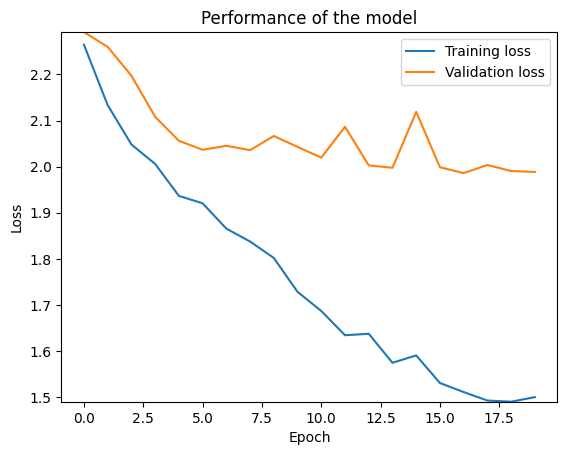

Training process has finished.


In [1639]:
if __name__ == '__main__':
    torch.manual_seed(42)
    #use cifar
    optimiser = torch.optim.SGD(model.parameters(), lr = .01)
    #use CrossEntropyLoss
    train_model(optimiser, model, nn.CrossEntropyLoss(),train_loadpck,val_loadpck,
                n_epochs = 20, fplotloss = True, fdraw = True, mode = 0);

---

In [1640]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [1641]:
#Building the model again:
#define my own CNN architecture 
class mySmallCNN_AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                             #Conv block
                             nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 2), #layer 1

                             #hidden 2
                             nn.ReLU(inplace = True),
                             nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 2, padding = 1),
                            
                             #hidden 3
                             nn.BatchNorm2d(32),
                             nn.ReLU(inplace = True),
                             nn.MaxPool2d(kernel_size = 4, stride = 2))
        
        self.decoder = nn.Sequential(
                            nn.Dropout(p = 0.1),
                            nn.ConvTranspose2d(32, 16, kernel_size = 2),
                            nn.ReLU(inplace = True),
                            nn.Dropout(p = 0.1),
                            nn.ConvTranspose2d(16, 3, kernel_size = 3),
                            nn.Softmax(dim = 1))
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [1642]:
print('My model: ')
print(mySmallCNN_AE())

My model: 
mySmallCNN_AE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1))
    (5): Softmax(dim=1)
  )
)


In [1650]:
transform = transforms.ToTensor()

In [1653]:
dataiter = iter(train_loadpck)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [1655]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        #N, 3, 32 *32 1024
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 2, padding = 1), #first conv layer
            nn.ReLU(),
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 2, padding = 1),
            )
          
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 32),
            nn.Sigmoid() #or softmax
            )
    
    def forward(self,x):
        encoded_val = self.encoder(x)
        decoded_val = self.decoder(encoded_val)
        return decoded_val

In [1664]:
model = CNNAutoEncoder()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [1665]:
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in train_loadpck:
        img = img.reshape(-1, 32*32)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch + 1}, loss: {loss.item():.4f}')
    outputs.append((epoch,img, recon))

Epoch: 1, loss: 3190.4968
Epoch: 2, loss: 3190.4146
Epoch: 3, loss: 3190.3367
Epoch: 4, loss: 3190.2588
Epoch: 5, loss: 3190.1758
Epoch: 6, loss: 3190.0857
Epoch: 7, loss: 3189.9871
Epoch: 8, loss: 3189.8779
Epoch: 9, loss: 3189.7568
Epoch: 10, loss: 3189.6243


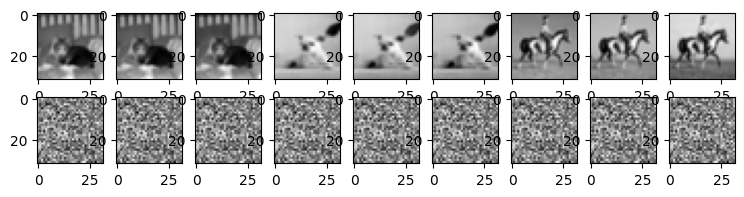

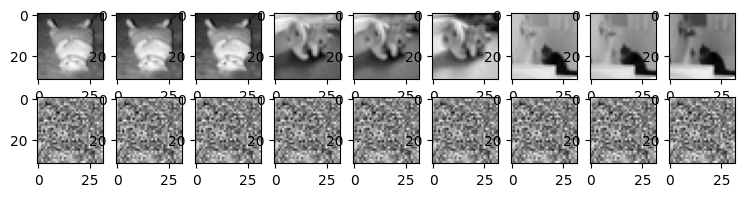

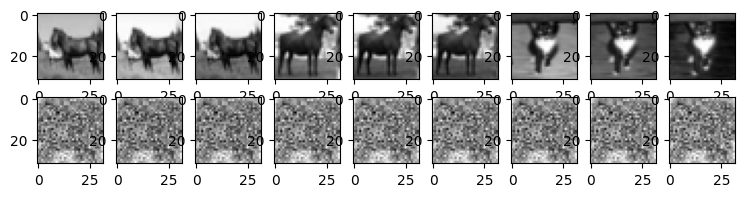

In [1663]:
for k in range(0, n_epochs, 4):
    plt.figure(figsize = (9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2,9, i+1)
        item = item.reshape(-3, 32, 32)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9 , 9+i+1) #row_length + i + 1
        item = item.reshape(-3, 32, 32)
        #item: 1, 28, 28
        plt.imshow(item[0])